# Notebook pour l'approche non supervisée
génère des modèles utilisant BERT, KMeans et Latent Dirichlet Allocation (LDA) pour l'analyse de texte. Il s'appuie sur des embeddings générés par BERT, la classification non supervisée avec KMeans, et la modélisation de sujets avec LDA. Les résultats sont ensuite visualisés et journalisés dans MLflow pour suivi.

### Configuration et importation de bibliotheques

In [1]:
import os
import joblib
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import mlflow.tensorflow
from dotenv import load_dotenv
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Charge l'environnement et  config mlflow
tracking_uri = "https://mlflowp51-975919512217.us-central1.run.app"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Text_Processing_Experiment")

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "f8bc1d91ca98.json"

# données
def load_dataframe():
    df = pd.read_csv('db/cleaned_data_sample.csv')
    return df

# charge model artefacts utilisés
def load_model_objects():
    with open('mlflow_artifacts/vectorizer.pkl', 'rb') as f:
        vectorizer = joblib.load(f)
    with open('mlflow_artifacts/svd.pkl', 'rb') as f:
        svd = joblib.load(f)
    with open('mlflow_artifacts/top_tags.pkl', 'rb') as f:
        top_tags = joblib.load(f)
    with open('mlflow_artifacts/X_use_embeddings.pkl', 'rb') as f:
        X_use_np = joblib.load(f)
    with open('mlflow_artifacts/y.pkl', 'rb') as f:
        y = joblib.load(f)
    return vectorizer, svd, top_tags, X_use_np, y

# données et models
df = load_dataframe()
vectorizer, svd, top_tags, X_use_np, y = load_model_objects()
X = vectorizer.transform(df['Cleaned_Body'])


### Initialisation du modèle Bert
Bert pré-entrainé et un tokenizer sont initialisés pour générer des embeddings à partir des textes

In [3]:

# initialise BERT model pour l'embeddings
def initialize_bert_model():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    return tokenizer, bert_model

# Transforme le texte en mbeddings avec BERT
def transform_text_to_embedding(text, tokenizer, bert_model):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True, max_length=128)
    outputs = bert_model(inputs)
    embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()
    return embeddings

# Appel du Bert model
tokenizer, bert_model = initialize_bert_model()

# Genere l'embeddings pour le corpus nettoyé du corps du message
embeddings = np.vstack(df['Cleaned_Body'].apply(lambda x: transform_text_to_embedding(x, tokenizer, bert_model)).values)


c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

### Clustering avec Kmeans et évaluation du nombre de cluster
Le nombre optimal de clusters est déterminé avec le score de silhouette. Néanmoins ce nombre n'est pas utilisé, et 4 clusters ont été définis pour le test.
Le modèle Kmeans est ensuite entrainé avec les embeddings BERT défini avant pour regrouper les textes en cluster

Pour n_clusters = 2, le score de silhouette moyen est : 0.11439096182584763
Pour n_clusters = 3, le score de silhouette moyen est : 0.10598776489496231
Pour n_clusters = 4, le score de silhouette moyen est : 0.06987746059894562
Pour n_clusters = 5, le score de silhouette moyen est : 0.04709065333008766
Pour n_clusters = 6, le score de silhouette moyen est : 0.042083628475666046
Pour n_clusters = 7, le score de silhouette moyen est : 0.03937775641679764
Pour n_clusters = 8, le score de silhouette moyen est : 0.029982155188918114
Pour n_clusters = 9, le score de silhouette moyen est : 0.03322090953588486
Pour n_clusters = 10, le score de silhouette moyen est : 0.02966366708278656


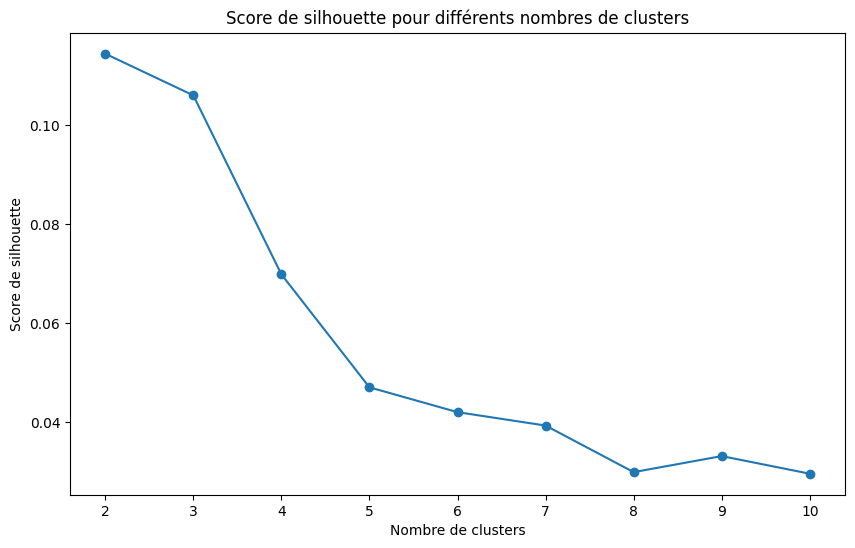

Le nombre optimal de clusters est : 2


In [4]:
# evalue le nombre de cluster avec le score silhouette
def evaluate_kmeans_clustering(embeddings, range_n_clusters):
    silhouette_scores = []
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(embeddings)
        cluster_labels = kmeans.predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Pour n_clusters = {n_clusters}, le score de silhouette moyen est : {silhouette_avg}")
        mlflow.log_metric(f"silhouette_score_n_clusters_{n_clusters}", silhouette_avg)
    return silhouette_scores

# evalue le cluster
range_n_clusters = range(2, 11)
silhouette_scores = evaluate_kmeans_clustering(embeddings, range_n_clusters)

# graphique des clusters et scores silhouettes
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.title("Score de silhouette pour différents nombres de clusters")
plt.show()

# nombre ideal de cluster
optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Le nombre optimal de clusters est : {optimal_n_clusters}")

# entraine kmeans model avec 4 clusters
def train_kmeans_model(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    mlflow.log_metric("kmeans_optimal_clusters", n_clusters)  # Log KMeans metrics
    return kmeans

kmeans = train_kmeans_model(embeddings, 4)


### Graphique visualisation de clusters Kmeans
Les résultats du clustering sont visualisés en 2D à l'aide de PCA, ce qui permet de représenter les differents thèmes sur un graphique.

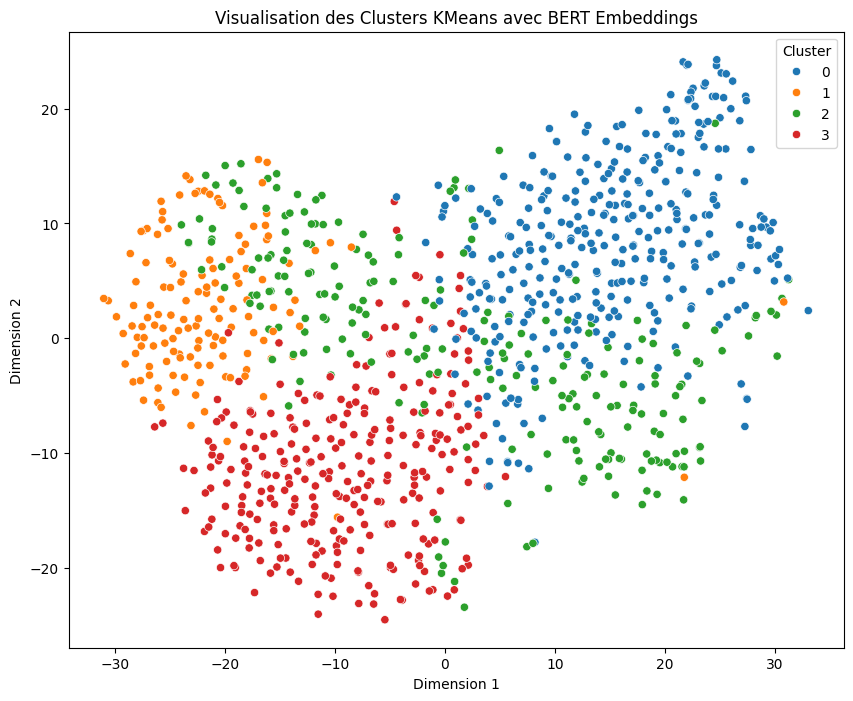

In [5]:
def plot_kmeans_clusters(embeddings, kmeans, method='tsne'):
    if method == 'pca':
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)
    
    # Obtient les labels des clusters pour chaque point
    cluster_labels = kmeans.predict(embeddings)

    # Visualisation avec Seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=cluster_labels, palette='tab10', legend='full')
    plt.title('Visualisation des Clusters KMeans avec BERT Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(title='Cluster')
    plt.show()

# Appel pour visualiser les clusters
plot_kmeans_clusters(embeddings, kmeans, method='tsne')

### Suggestion de tags avec KMeans
Le modèle KMeans est utilisé pour suggérer des tags pour de nouvelles questions basées sur leur appartenance à un cluster.

In [6]:

# filtre `y` pour une vérification et preservatioin des tailles entre x et y
y_filtered = y[:len(X_use_np)]
assert len(y_filtered) == len(X_use_np), "Les tailles de y et des embeddings ne correspondent pas"

# Suggestions de tags pour des questions données sur kmeans
def suggest_tags(text, kmeans, tokenizer, bert_model, top_tags):
    embedding = transform_text_to_embedding(text, tokenizer, bert_model)
    cluster = kmeans.predict(embedding)
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]

    print(f"Indices des points dans le même cluster: {cluster_indices}")

    # Filtre les indices pour eviter d'avoir des index hors du traitement
    cluster_indices = [idx for idx in cluster_indices if idx < len(y_filtered)]

    tag_counts = {}
    for idx in cluster_indices:
        tags = y_filtered[idx]
        for i, tag_active in enumerate(tags):
            if tag_active:  # si le tag est actif 1
                tag_name = top_tags[i]
                if tag_name in tag_counts:
                    tag_counts[tag_name] += 1
                else:
                    tag_counts[tag_name] = 1

    sorted_tags = sorted(tag_counts.items(), key=lambda item: item[1], reverse=True)
    suggested_tags = [tag for tag, count in sorted_tags[:10]]  # Limit: 10
    return suggested_tags

# Exemple de questions a tester
test_questions = ["how to center a div?", "what is the best way to sort a list in Python?", "how to create a neural network?"]

for question in test_questions:
    suggested_tags = suggest_tags(question, kmeans, tokenizer, bert_model, top_tags)
    print(f"Suggested tags for '{question}': {suggested_tags}")

Indices des points dans le même cluster: [  5   7  12  13  17  18  19  20  22  23  26  28  29  31  33  36  38  39
  40  45  56  57  61  62  65  68  71  76  77  78  81  82  89  94  95  99
 102 104 119 120 122 127 128 129 131 132 136 137 141 142 145 147 154 156
 163 165 170 174 179 180 191 202 207 210 216 222 226 232 234 235 241 242
 243 244 246 248 250 255 256 257 258 259 264 269 272 274 277 278 280 283
 285 288 290 294 299 303 306 307 308 311 314 315 319 323 324 332 336 339
 340 344 347 348 354 355 360 364 366 372 375 376 377 378 379 381 390 401
 403 407 411 412 413 414 418 424 425 430 431 432 438 439 446 449 451 456
 460 462 467 473 476 477 479 498 500 502 506 508 510 520 528 532 539 540
 543 550 556 558 573 581 582 583 585 586 598 599 600 601 603 611 621 624
 626 632 633 635 638 639 642 644 646 650 652 653 654 655 657 666 670 673
 675 680 684 685 686 696 699 702 704 706 707 717 718 721 722 729 734 743
 755 761 771 778 783 785 795 799 801 802 803 804 806 808 812 815 816 825
 826 833 8

### Modélisation des sujets avec LDA
Le modèle Latent Dirichlet Allocation (LDA) est utilisé pour extraire des topics à partir des données textuelles. GridSearchCV est utilisé pour optimiser les hyperparamètres du modèle.

2024/10/11 20:49:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-bee-53 at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/b257be59702c42afa132c368546cfa35.
2024/10/11 20:49:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.
2024/10/11 20:51:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/11 20:51:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 20:51:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run LDA_Model_Training at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/b9ec4b8445494084824988c249dd38e1.
2024/10/11 20:51:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217

Topic #0:
public class return and true the new implementation private import
Topic #1:
the from const ltdiv and ltdivgt value return this npm
Topic #2:
the return int with for function array and this error
Topic #3:
the file quotquot error and from this run not line
Topic #4:
the and this that for but have with not can



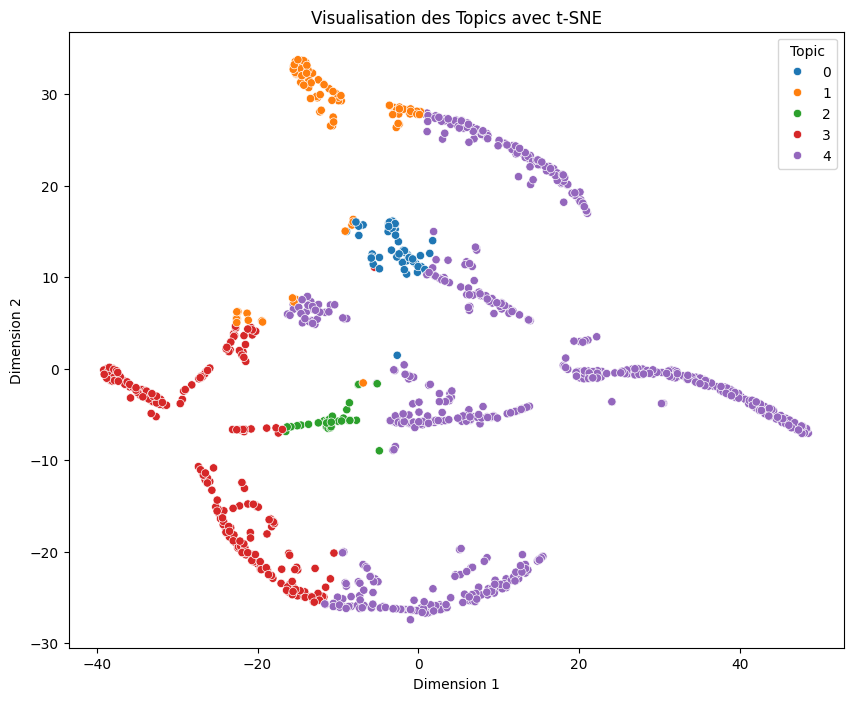

Dominant Topic: 4, Distribution: [0.05149575 0.05063077 0.05002285 0.05016739 0.79768324]
Suggested tags for 'how to center a div?': ['reactjs']
Dominant Topic: 4, Distribution: [0.02509389 0.02529287 0.02523132 0.02564802 0.89873388]
Suggested tags for 'what is the best way to sort a list in Python?': ['reactjs']
Dominant Topic: 3, Distribution: [0.05056771 0.05077262 0.05015251 0.7960466  0.05246056]
Suggested tags for 'how to create a neural network?': ['java']


In [7]:
mlflow.end_run()


# LDA model avec GridSearchCV et des hyperparametres optimisés
search_params = {'n_components': [5, 10, 15, 20], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation(random_state=42)
model = GridSearchCV(lda, param_grid=search_params)
model.fit(X)

# Meilleurs LDA model trouvé par GridSearchCV
best_lda_model = model.best_estimator_

# Journalisation du modèle LDA dans MLflow
with mlflow.start_run(run_name="LDA_Model_Training"):
    mlflow.log_param("n_topics", model.best_params_['n_components'])
    mlflow.sklearn.log_model(best_lda_model, "LDA_Model")
mlflow.end_run()
# Extraction des mots-clés pour chaque topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# Affichage des mots-clés pour chaque topic
n_top_words = 10
print_top_words(best_lda_model, vectorizer.get_feature_names_out(), n_top_words)

# Réduction de la dimensionnalité avec t-SNE pour visualiser en 2D
topic_distributions = best_lda_model.transform(X)
tsne = TSNE(n_components=2, random_state=42)
topic_distributions_2d = tsne.fit_transform(topic_distributions)

# Topics en 2D
plt.figure(figsize=(10, 8))
sns.scatterplot(x=topic_distributions_2d[:, 0], y=topic_distributions_2d[:, 1], hue=topic_distributions.argmax(axis=1), palette='tab10')
plt.title('Visualisation des Topics avec t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Topic')
plt.show()


# Suggestion de tags basée sur LDA
def suggest_tags_lda(text, vectorizer, lda_model, top_tags):
    # Transforme le texte en une matrice BoW (bag-of-words)
    text_transformed = vectorizer.transform([text])
    
    # Obtiens les probabilité des topics pour ce texte
    topic_distribution = lda_model.transform(text_transformed)[0]
    
    # Sélectionne le tag dominant
    dominant_topic = np.argmax(topic_distribution)
    
    print(f"Dominant Topic: {dominant_topic}, Distribution: {topic_distribution}")
    
    # Retourner les tags associés aux points qui sont le plus proches de ce topic
    # Relit les topics dominants à des tags pertinents
    # Chaque topic est associé à une liste de tags.
    suggested_tags = [top_tags[dominant_topic]]  #  utilise le tag comme suggestion
    
    return suggested_tags

# Test avec des questions d'exemple et suggestions de tags basées sur LDA
test_questions = ["how to center a div?", "what is the best way to sort a list in Python?", "how to create a neural network?"]

for question in test_questions:
    suggested_tags = suggest_tags_lda(question, vectorizer, best_lda_model, top_tags)
    print(f"Suggested tags for '{question}': {suggested_tags}")

### Journalisation des modèles dans MLflow
Tous les modèles (KMeans, LDA, BERT) ainsi que leurs métriques et artefacts sont enregistrés dans MLflow pour suivi.


In [8]:

# Répertoire de sauvegarde des modèles dans mlflow_artifacts
model_save_directory = "mlflow_artifacts/"
os.makedirs(model_save_directory, exist_ok=True)
mlflow.end_run()
# Journalisation des modèles KMeans, LDA et BERT dans MLflow
with mlflow.start_run(run_name="KMeans_Clustering"):
    kmeans_model_path = os.path.join(model_save_directory, "KMeans_Model")
    mlflow.sklearn.log_model(kmeans, artifact_path=kmeans_model_path)
    print(f"KMeans model saved to: {kmeans_model_path}")
mlflow.end_run()
with mlflow.start_run(run_name="LDA_Model_Training"):
    lda_model_path = os.path.join(model_save_directory, "LDA_Model")
    mlflow.sklearn.log_model(best_lda_model, artifact_path=lda_model_path)
    print(f"LDA model saved to: {lda_model_path}")
mlflow.end_run()
with mlflow.start_run(run_name="BERT_Model_Training"):
    bert_model_path = os.path.join(model_save_directory, "BERT_Model")
    mlflow.tensorflow.log_model(bert_model, artifact_path=bert_model_path)
    print(f"BERT model saved to: {bert_model_path}")
mlflow.end_run()

2024/10/11 20:51:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 20:51:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run KMeans_Clustering at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/09e979c048934d54baf677ae79b0a1ae.
2024/10/11 20:51:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


KMeans model saved to: mlflow_artifacts/KMeans_Model


2024/10/11 20:51:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/11 20:51:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 20:51:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run LDA_Model_Training at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/a8feca04a1da420ca99a301d002b9caa.
2024/10/11 20:51:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


LDA model saved to: mlflow_artifacts/LDA_Model


2024/10/11 20:51:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\leenc\AppData\Local\Temp\tmp280wbabh\model\tf2model\assets


INFO:tensorflow:Assets written to: C:\Users\leenc\AppData\Local\Temp\tmp280wbabh\model\tf2model\assets
2024/10/11 20:52:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 20:53:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run BERT_Model_Training at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/743eab5f36604515af51f5097d9f347c.
2024/10/11 20:53:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


BERT model saved to: mlflow_artifacts/BERT_Model
